In [41]:
# Install packages if needed with this command: 
# !pip install -r requirements.txt
import os
import kaggle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# From here, add any libraries that you might need for the rest of your code
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, accuracy_score, f1_score, recall_score
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import scipy.ndimage
from skimage.filters import median, laplace
from skimage.morphology import disk
from skimage.restoration import denoise_nl_means, estimate_sigma, denoise_wavelet, calibrate_denoiser
from skimage import img_as_float, transform, exposure, io, util
from skimage.metrics import peak_signal_noise_ratio as psnr

In [9]:
data_dir = 'driver-inattention-detection-dataset'

## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# read the file containing the class labels
with open(os.path.join(data_dir, 'train', '_classes.txt')) as f: 
    classes = list(map(str.strip, f))

# read image paths and labels and store them in pandas dataframes
with open(os.path.join(data_dir, 'test', '_annotations.txt'), 'r') as f: 
    df_test = pd.DataFrame(dict(img=os.path.join(data_dir, 'test', line.split()[0]), 
                                label=classes[int(line.strip()[-1])]) for line in f)
    
with open(os.path.join(data_dir, 'valid', '_annotations.txt'), 'r') as f: 
    df_val = pd.DataFrame(dict(img=os.path.join(data_dir, 'valid', line.split()[0]), 
                               label=classes[int(line.strip()[-1])]) for line in f)
    
with open(os.path.join(data_dir, 'train', '_annotations.txt'), 'r') as f: 
    df_train = pd.DataFrame(dict(img=os.path.join(data_dir, 'train', line.split()[0]), 
                                 label=classes[int(line.strip()[-1])]) for line in f if len(line.split())>1)

# pre-processing parameters
image_unit_res = 8
img_height, img_width = 9*image_unit_res, 16*image_unit_res # 16:9 preserve aspect ratio
batch_size = 32

def add_noise(img):
    std_coeff = 50*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

data_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

train_data = data_gen.flow_from_dataframe(
    df_train, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale')

val_data = data_gen.flow_from_dataframe(
    df_val, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')

test_data = data_gen.flow_from_dataframe(
    df_test, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')


Found 11948 validated image filenames belonging to 6 classes.
Found 1922 validated image filenames belonging to 6 classes.
Found 985 validated image filenames belonging to 6 classes.


In [10]:
# Convert the target testues using the proper function for one hot encoding.
## CONFUSED AS THEY ARE ALREADY IN ONE HOT ENCODING
from tensorflow.keras.utils import to_categorical

# Extract the number of target classes
num_classes = len(np.unique(train_data.classes))

# one-hot encode the integer labels
y_train = to_categorical(train_data.classes, num_classes=num_classes)
y_test = to_categorical(test_data.classes, num_classes=num_classes)
y_test = to_categorical(test_data.classes, num_classes=num_classes)


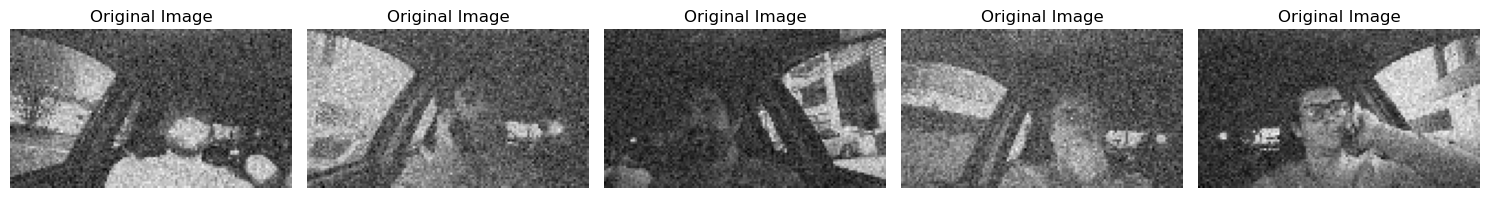

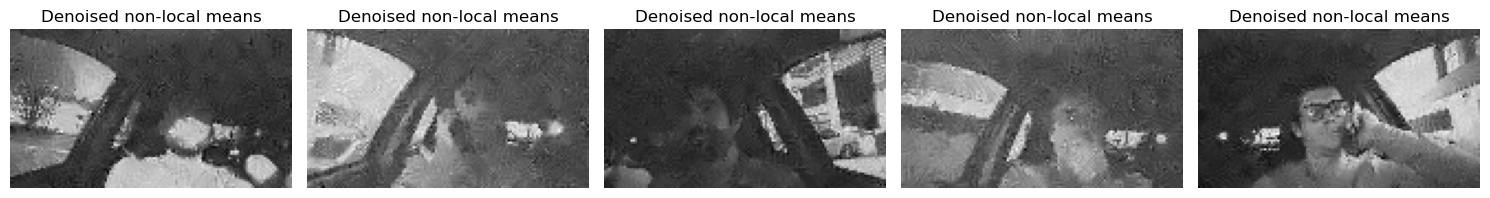

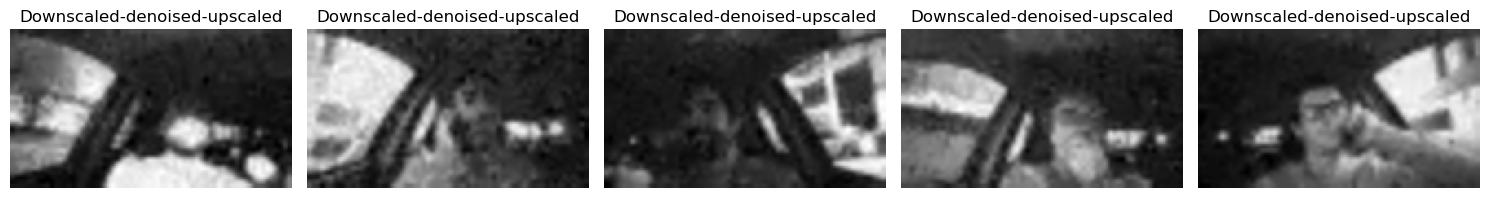

In [11]:
# Randomly select 15 samples from the dataset. For each selected sample, display the image along with its corresponding label as text on top of the image. 
# Arrange 2 these images and labels in a single figure, ensuring that they are visually clear and labeled properly

# Get images and labels from the training data
images, labels = next(train_data)
# images.shape => (32, 72, 128, 1)  # batch_size=32, H=72, W=128, 1=grayscale
# labels.shape => (32, 6)          # one-hot vectors for 6 classes
    
# Randomly select 15 samples
selected_images = images[0:5]

# Create a figure and axes for the images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes = axes.ravel()

for i in range(len(selected_images)):
    ax = axes[i]
    
    image = selected_images[i]
    image_squeezed = np.squeeze(image) # remove channel dimensions of images

    # ---- Plot the image ----
    ax.imshow(image_squeezed, cmap='gray')
    ax.set_title("Original Image")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Create a figure and axes for the images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes = axes.ravel()

for i in range(len(selected_images)):
    ax = axes[i]
    
    image = selected_images[i]
    image_squeezed = np.squeeze(image) # remove channel dimensions of images
    image_float = img_as_float(image_squeezed)

    # Denoising
    sigma_est = np.mean(estimate_sigma(image_float))
    image_denoised = denoise_nl_means(image_float, h=1.*sigma_est, fast_mode=False, 
                                      patch_size=5, patch_distance=3)
    
    # ---- Plot the image ----
    ax.imshow(image_denoised, cmap='gray')
    ax.set_title("Denoised non-local means")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Create a figure and axes for the images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes = axes.ravel()

for i in range(len(selected_images)):
    ax = axes[i]
    
    image = selected_images[i]
    image_squeezed = np.squeeze(image) # remove channel dimensions of images
    image_float = img_as_float(image_squeezed)

    ## Image augmentation

    # Downscaling
    scale_factor = 0.5
    image_downscaled = transform.rescale(image_float, scale_factor, anti_aliasing=True)

    # Denoising
    sigma_est = np.mean(estimate_sigma(image_downscaled))
    image_denoised = denoise_nl_means(image_downscaled, h=0.8*sigma_est, fast_mode=False, 
                                      patch_size=5, patch_distance=3)
    
    # Upscaling
    image_upscaled = transform.rescale(image_denoised, 1 / scale_factor, anti_aliasing=True)
    
    # ---- Plot the image ----
    ax.imshow(image_upscaled, cmap='gray')
    ax.set_title("Downscaled-denoised-upscaled")
    ax.axis('off')
plt.tight_layout()
plt.show()

## Comparing smoothing filters

In [12]:
images, labels = next(train_data)
img = images[0]
img = np.squeeze(img)
print(img.min(), img.max(), img.dtype)
img = img_as_float(img)
print(img.min(), img.max(), img.dtype)

# --- Step 2: Downsample the noisy image ---
scale_factor = 0.5  # e.g., reduce size by half
img_small = transform.rescale(img, scale_factor, anti_aliasing=True)

# --- Step 3: Denoise the downsampled image using different methods ---

# 1. Non-Local Means (NLM)
sigma_est = np.mean(estimate_sigma(img))
denoised_nlm = denoise_nl_means(img, h=1.15*sigma_est, fast_mode=False, 
                                      patch_size=5, patch_distance=3)

sigma_est = np.mean(estimate_sigma(img_small))
denoised_nlm_small = denoise_nl_means(img_small, h=1.15*sigma_est, fast_mode=False, 
                                      patch_size=5, patch_distance=3)

# 2. Contrast enhancement
img_adapthist = exposure.equalize_adapthist(img)

# 3. Laplacian filter
laplacian = laplace(img)
alpha = 0.5
minus_sharp = img - alpha * laplacian
plus_laplace = img + alpha * laplacian

# --- Step 4: Upscale the small denoised images back to original resolution ---
denoised_nlm_up = transform.rescale(denoised_nlm_small, 1/scale_factor, anti_aliasing=True)

# --- Step 5: Plot the results ---
plt.figure(figsize=(15, 10))

# Original Image
plt.subplot(332)
plt.imshow(img, cmap='gray')
plt.title(f"Original Noisy Image")
plt.axis('off')

# Denoised with Non-Local Means
plt.subplot(334)
plt.imshow(denoised_nlm, cmap='gray')
plt.title("Non-Local Means")
plt.axis('off')

# Denoised with Wavelet
plt.subplot(335)
plt.imshow(img_adapthist, cmap='gray')
plt.title("Adaptive histogram equalization")
plt.axis('off')

# Denoised with Median filter
plt.subplot(336)
plt.imshow(minus_sharp, cmap='gray')
plt.title("Minus Laplacian filter")
plt.axis('off')

# Denoised with Non-Local Means then Upscaled
plt.subplot(337)
plt.imshow(denoised_nlm_up, cmap='gray')
plt.title("Non-Local Means\nDenoised & Upscaled")
plt.axis('off')

# Denoised with Wavelet then Upscaled
plt.subplot(338)
plt.imshow(denoised_wavelet_up, cmap='gray')
plt.title("Wavelet Denoised\n& Upscaled")
plt.axis('off')

# Denoised with Median filter then Upscaled
plt.subplot(339)
plt.imshow(plus_laplace, cmap='gray')
plt.title("Plus Laplacian filter")
plt.axis('off')

plt.tight_layout()
plt.show()


-0.5304003 1.5820509 float32
-0.5304003 1.5820509 float32


ValueError: Images of type float must be between -1 and 1.

## Non-local means denoising

1.342613 -0.2695549 (72, 128)
1.342613 -0.2695549 (72, 128)


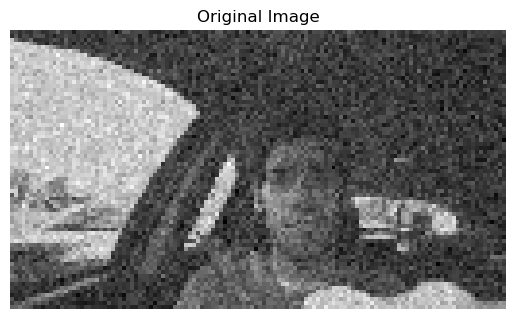

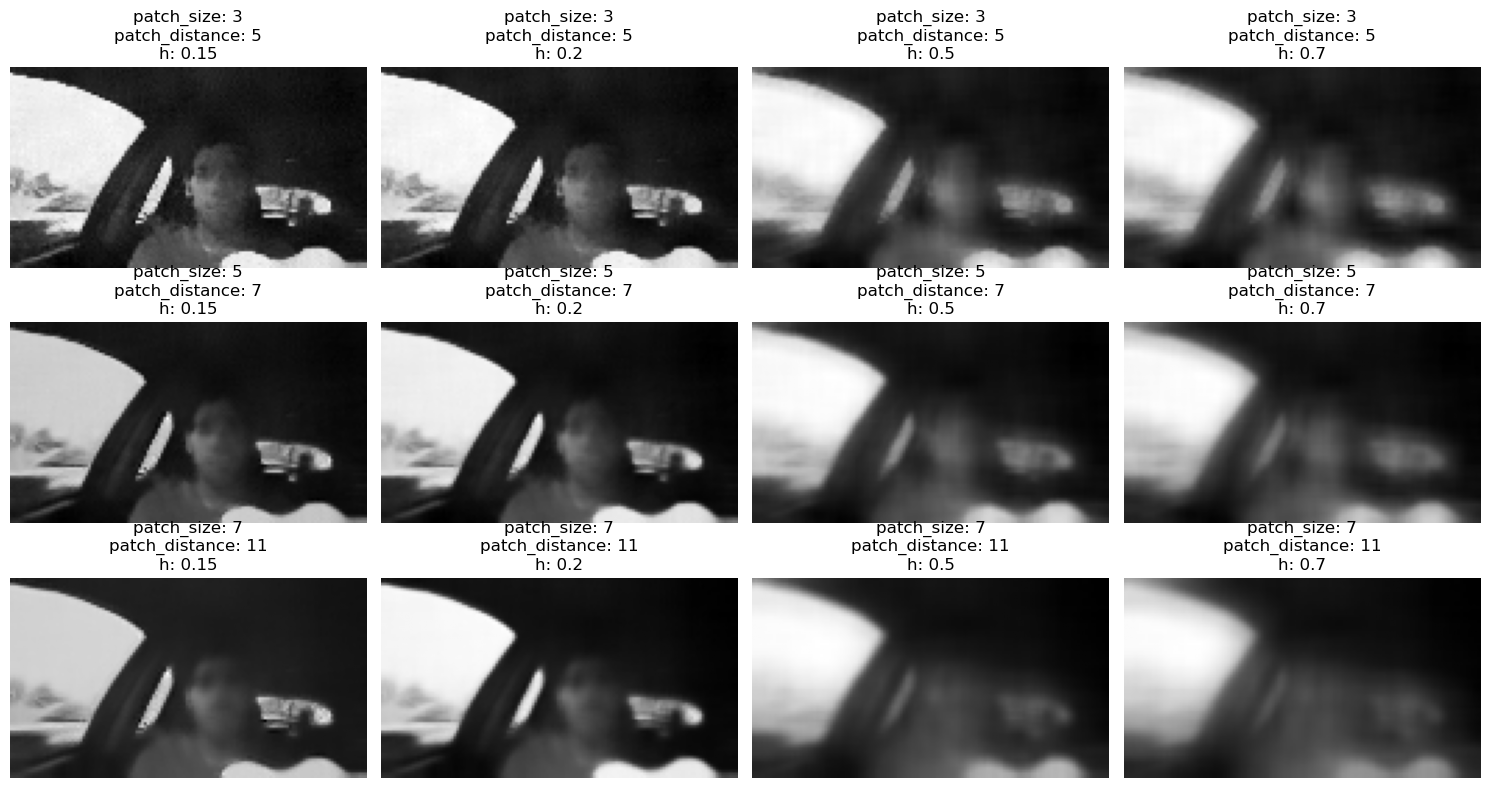

In [ ]:
images, labels = next(train_data)
img = images[0]
img = np.squeeze(img)

print(img.max(), img.min(), img.shape)

img = img_as_float(img)

print(img.max(), img.min(), img.shape)

# --- Step 2: Define different NLM parameter sets ---
# Each dictionary contains parameters for denoise_nl_means
param_list = [
    {"patch_size": 3, "patch_distance": 5, "h": 0.15},
    {"patch_size": 3, "patch_distance": 5, "h": 0.2},
    {"patch_size": 3, "patch_distance": 5, "h": 0.5},
    {"patch_size": 3, "patch_distance": 5, "h": 0.7},
    {"patch_size": 5, "patch_distance": 7, "h": 0.15},
    {"patch_size": 5, "patch_distance": 7, "h": 0.2},
    {"patch_size": 5, "patch_distance": 7, "h": 0.5},
    {"patch_size": 5, "patch_distance": 7, "h": 0.7},
    {"patch_size": 7, "patch_distance": 11, "h": 0.15},
    {"patch_size": 7, "patch_distance": 11, "h": 0.2},
    {"patch_size": 7, "patch_distance": 11, "h": 0.5},
    {"patch_size": 7, "patch_distance": 11, "h": 0.7},
]

denoised_results = []

# --- Step 3: Apply Non-Local Means denoising with each parameter set ---
for params in param_list:
    denoised = denoise_nl_means(
        img,
        patch_size=params["patch_size"],
        patch_distance=params["patch_distance"],
        h=params["h"],
        fast_mode=True,
        channel_axis=None  # None for grayscale images
    )
    denoised_results.append(denoised)

# --- Step 4: Plot the results ---
n_cols = 4
n_rows = int(np.ceil((len(param_list)) / n_cols))

plt.figure()

# Show the noisy image first
plt.imshow(img, cmap='gray')
plt.title(f"Original Image")
plt.axis('off')

plt.figure(figsize=(15, 8))

# Plot each denoised result with its corresponding parameters
for i, params in enumerate(param_list, start=1):
    plt.subplot(n_rows, n_cols, i)
    plt.imshow(denoised_results[i-1], cmap='gray')
    title = (f"patch_size: {params['patch_size']}\n"
             f"patch_distance: {params['patch_distance']}\n"
             f"h: {params['h']}")
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

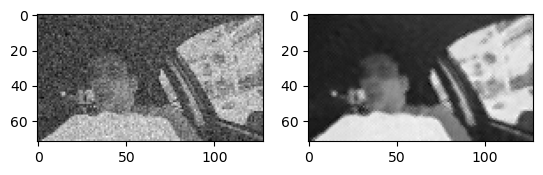

In [63]:
images, labels = next(train_data)
img = images[0]
img = np.squeeze(img)

param_list = {
    "patch_size": [3, 5, 7],
    "patch_distance": [5, 7, 9],
    "h": [0.1, 0.2, 0.5]
}

best_denoiser, params = calibrate_denoiser(img, denoise_nl_means, param_list, extra_output=True)

denoised_img = best_denoiser(img)

plt.subplot(121)
plt.imshow(img, cmap="gray")

plt.subplot(122)
plt.imshow(denoised_img, cmap="gray")

Image has been converted to float
2 (36, 64)
Random noise has been added
Image 1 has been denoised
2 (36, 64)
Denoising has been analysed
1 out of 27 done
Image 2 has been denoised
2 (36, 64)
Denoising has been analysed
2 out of 27 done
Image 3 has been denoised
2 (36, 64)
Denoising has been analysed
3 out of 27 done
Image 4 has been denoised
2 (36, 64)
Denoising has been analysed
4 out of 27 done
Image 5 has been denoised
2 (36, 64)
Denoising has been analysed
5 out of 27 done
Image 6 has been denoised
2 (36, 64)
Denoising has been analysed
6 out of 27 done
Image 7 has been denoised
2 (36, 64)
Denoising has been analysed
7 out of 27 done
Image 8 has been denoised
2 (36, 64)
Denoising has been analysed
8 out of 27 done
Image 9 has been denoised
2 (36, 64)
Denoising has been analysed
9 out of 27 done
Image 10 has been denoised
2 (36, 64)
Denoising has been analysed
10 out of 27 done
Image 11 has been denoised
2 (36, 64)
Denoising has been analysed
11 out of 27 done
Image 12 has been den

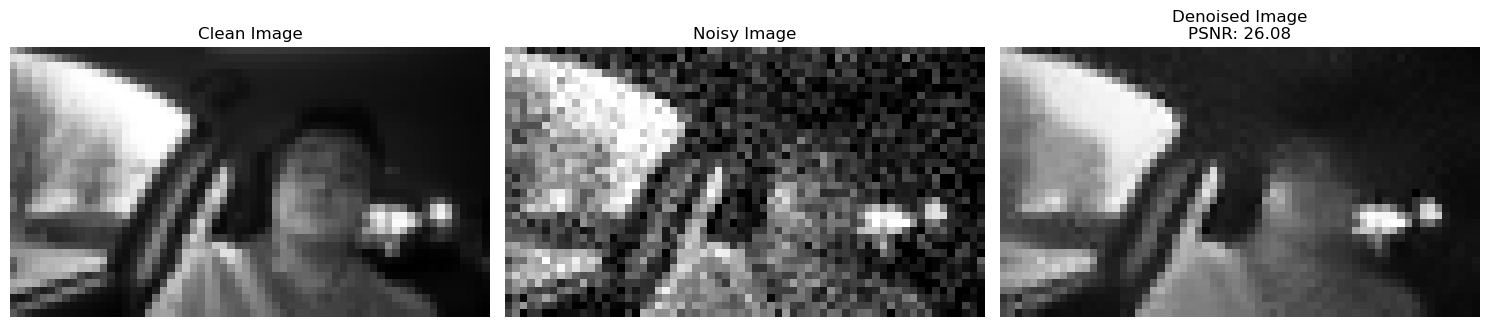

In [40]:
im = io.imread("C:/Users/lvers/OneDrive/Documents/GitHub/Deep_learning_03/driver-inattention-detection-dataset/train/gA_1_s1_ir_face_mp4-1_jpg.rf.054a08cc8325b4f67b3c254e05aae9d2.jpg", 
               as_gray=True)
im = transform.rescale(im, 0.1, anti_aliasing=True)

# Load a clean image and convert it to float [0, 1]
clean_img = img_as_float(im)
print("Image has been converted to float")
print(clean_img.ndim, clean_img.shape)

# Add synthetic Gaussian noise to the clean image
sigma = 0.1  # standard deviation for noise
noisy_img = util.random_noise(clean_img, mode='gaussian', var=sigma**2)
print("Random noise has been added")

# Define the grid of parameters to search over
patch_sizes = [3, 5, 7]
patch_distances = [5, 7, 9]
h_values = [0.1, 0.15, 0.2]

best_params = None
best_psnr = -np.inf
results = []

loop_nr = 1

# Grid search loop
for patch_size in patch_sizes:
    for patch_distance in patch_distances:
        for h in h_values:
            denoised = denoise_nl_means(
                noisy_img,
                patch_size=patch_size,
                patch_distance=patch_distance,
                h=h,
                fast_mode=True,
                channel_axis=None  # None for grayscale images
            )

            print("Image", loop_nr, "has been denoised")
            print(denoised.ndim, denoised.shape)
            
            # Evaluate the denoised image using PSNR against the clean image
            current_psnr = psnr(clean_img, denoised)
            results.append({
                "patch_size": patch_size,
                "patch_distance": patch_distance,
                "h": h,
                "psnr": current_psnr
            })

            print("Denoising has been analysed")
            
            if current_psnr > best_psnr:
                best_psnr = current_psnr
                best_params = {"patch_size": patch_size, "patch_distance": patch_distance, "h": h}

            print(loop_nr, "out of 27 done")
            loop_nr += 1

print("Best Parameters:", best_params)
print("Best PSNR:", best_psnr)

# Optional: Plot the denoised image using the best parameters
best_denoised = denoise_nl_means(
    noisy_img,
    patch_size=best_params["patch_size"],
    patch_distance=best_params["patch_distance"],
    h=best_params["h"],
    fast_mode=True,
    channel_axis=None
)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(clean_img, cmap='gray')
plt.title("Clean Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_img, cmap='gray')
plt.title("Noisy Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(best_denoised, cmap='gray')
plt.title(f"Denoised Image\nPSNR: {best_psnr:.2f}")
plt.axis('off')
plt.tight_layout()
plt.show()
